## imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Use RandomForestClassifier for classification
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns


In [2]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [3]:
if False:
    # Example: Generate some synthetic data
    np.random.seed(42)
    n_samples = 30
    n_features = 12

    # Create a DataFrame with random features
    input_features = pd.DataFrame(np.random.randn(n_samples, n_features), columns=[f'feature_{i}' for i in range(n_features)])
    # Generate a continuous target variable (for regression)

    doy_label = np.random.randn(n_samples) * 0.5



## read data

In [82]:
df_feature_ONI = pd.read_csv('../../datasets/csv/ONI_data.csv')
df_feature_ONI = df_feature_ONI.rename(columns={'Year': 'year'})

print("before")
print(df_feature_ONI.head())

df_before_amj = df_feature_ONI.iloc[:, 1:2]  # From DJF
df_before_amj.columns = ["ONI_" + col for col in df_before_amj.columns]
df_before_amj["year"] = df_feature_ONI["year"]

df_after_amj = df_feature_ONI.iloc[:, 5:]   # From AMJ to NDJ (after AMJ)
df_after_amj.columns = ["ONI_" + col + '_prev' for col in df_after_amj.columns]
df_after_amj["year"] = df_feature_ONI["year"] + 1 # Increment the year for the second part (starting from AMJ)



df_feature_ONI = pd.merge(df_after_amj, df_before_amj, on='year', how='inner').dropna()

print("after")
print(df_feature_ONI.head())

before
   year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
0  1950 -1.5 -1.3 -1.2 -1.2 -1.1 -0.9 -0.5 -0.4 -0.4 -0.4 -0.6 -0.8
1  1951 -0.8 -0.5 -0.2  0.2  0.4  0.6  0.7  0.9  1.0  1.2  1.0  0.8
2  1952  0.5  0.4  0.3  0.3  0.2  0.0 -0.1  0.0  0.2  0.1  0.0  0.1
3  1953  0.4  0.6  0.6  0.7  0.8  0.8  0.7  0.7  0.8  0.8  0.8  0.8
4  1954  0.8  0.5  0.0 -0.4 -0.5 -0.5 -0.6 -0.8 -0.9 -0.8 -0.7 -0.7
after
   ONI_AMJ_prev  ONI_MJJ_prev  ONI_JJA_prev  ONI_JAS_prev  ONI_ASO_prev  \
0          -1.1          -0.9          -0.5          -0.4          -0.4   
1           0.4           0.6           0.7           0.9           1.0   
2           0.2           0.0          -0.1           0.0           0.2   
3           0.8           0.8           0.7           0.7           0.8   
4          -0.5          -0.5          -0.6          -0.8          -0.9   

   ONI_SON_prev  ONI_OND_prev  ONI_NDJ_prev  year  ONI_DJF  
0          -0.4          -0.6          -0.8  1951     -0.8  
1     

In [83]:
# Replace 'filename.csv' with the path to your CSV file
df_label = pd.read_csv('../../datasets/csv/cherry/doy_cherry_peak_bloom_Japan_Abashiri.csv')

# Display the first few rows of the DataFrame
print(df_label.head())

   year  doy_cherry_peak_bloom
0  1953                    146
1  1954                    139
2  1955                    140
3  1956                    134
4  1959                    127


In [84]:
# Merge and remove rows with missing values
merged_df = pd.merge(df_label, df_feature_ONI, on='year', how='inner').dropna()

# Split back into two DataFrames without 'ID'
df_label = merged_df[['doy_cherry_peak_bloom']]
df_feature_ONI = merged_df.drop(columns=['doy_cherry_peak_bloom'])

In [85]:
df_feature_ONI.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59],
           dtype='int64')

In [86]:
df_feature_ONI.head()

,year,ONI_AMJ_prev,ONI_MJJ_prev,ONI_JJA_prev,ONI_JAS_prev,ONI_ASO_prev,ONI_SON_prev,ONI_OND_prev,ONI_NDJ_prev,ONI_DJF
0,1953,0.2,0.0,-0.1,0.0,0.2,0.1,0.0,0.1,0.4
1,1954,0.8,0.8,0.7,0.7,0.8,0.8,0.8,0.8,0.8
2,1955,-0.5,-0.5,-0.6,-0.8,-0.9,-0.8,-0.7,-0.7,-0.7
3,1956,-0.8,-0.7,-0.7,-0.7,-1.1,-1.4,-1.7,-1.5,-1.1
4,1959,0.7,0.6,0.6,0.4,0.4,0.4,0.5,0.6,0.6


## eda

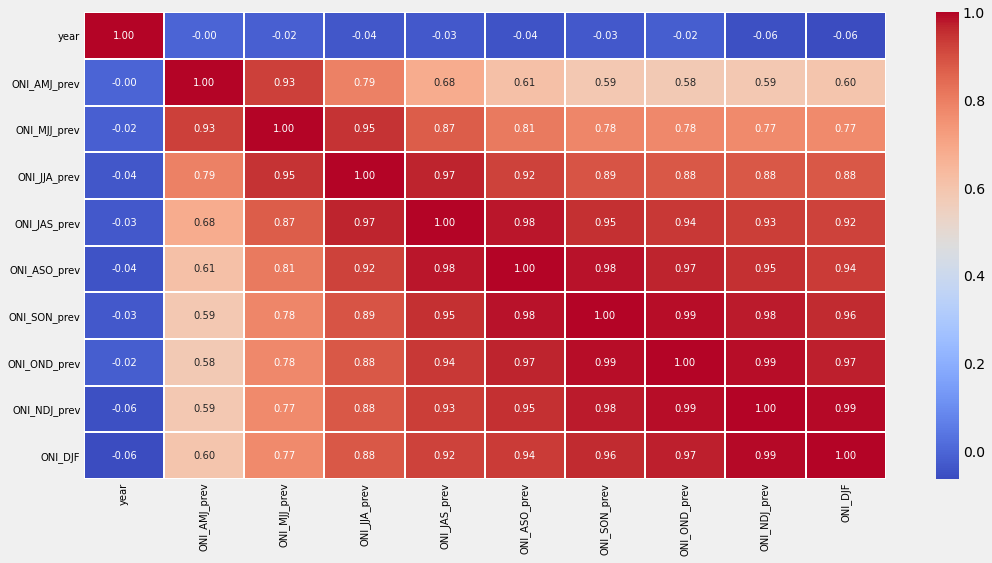

In [76]:
corr_matrix = df_feature_ONI.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

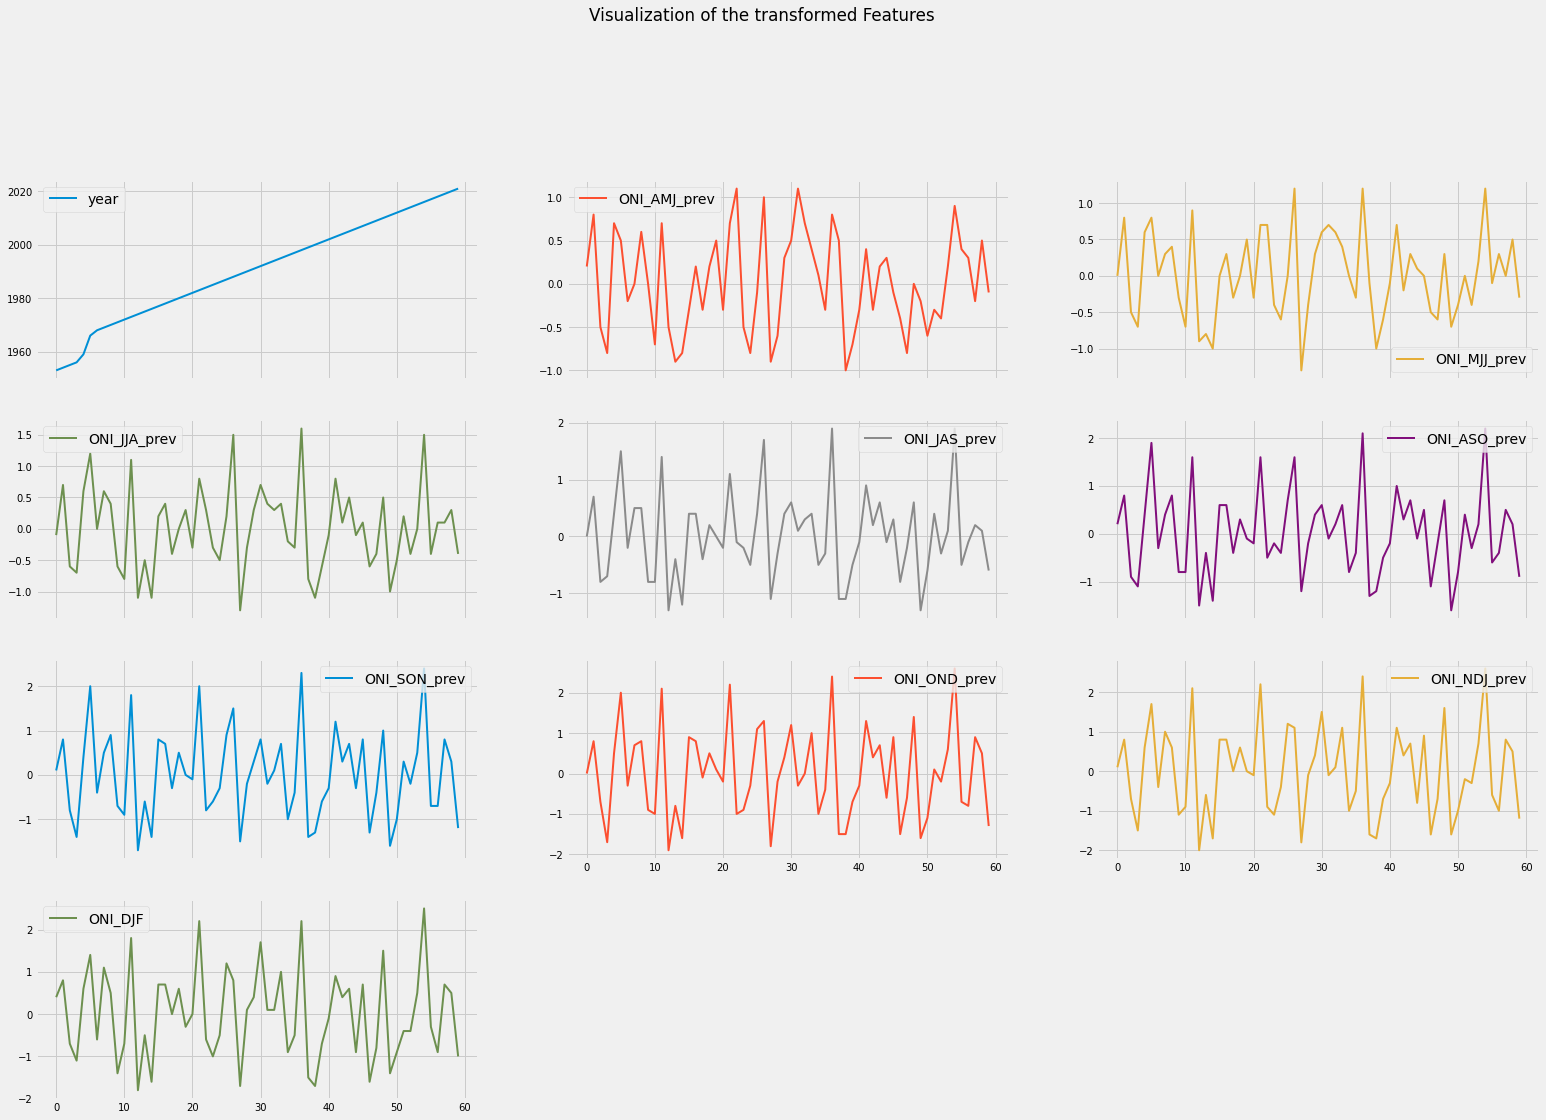

In [10]:
plt.style.use('fivethirtyeight')
df_feature_ONI.plot(subplots=True,
                  layout=(6, 3),
                  figsize=(24,24),
                  fontsize=10, 
                  linewidth=2, 
                  title='Visualization of the transformed Features')
plt.show()

## split data

In [11]:
input_features = df_feature_ONI# .drop(columns=["year"])
doy_label = df_label["doy_cherry_peak_bloom"]

print(input_features.head())
print(doy_label.head())

# Split the data into training and test sets
# input_features_train, input_features_test, doy_label_train, doy_label_test = train_test_split(input_features, doy_label, test_size=0.2, random_state=42)

input_features_train, input_features_test = input_features[:-5], input_features[-5:]
doy_label_train, doy_label_test = doy_label[:-5], doy_label[-5:]


   year  ONI_AMJ_prev  ONI_MJJ_prev  ONI_JJA_prev  ONI_JAS_prev  ONI_ASO_prev  \
0  1953           0.2           0.0          -0.1           0.0           0.2   
1  1954           0.8           0.8           0.7           0.7           0.8   
2  1955          -0.5          -0.5          -0.6          -0.8          -0.9   
3  1956          -0.8          -0.7          -0.7          -0.7          -1.1   
4  1959           0.7           0.6           0.6           0.4           0.4   

   ONI_SON_prev  ONI_OND_prev  ONI_NDJ_prev  ONI_DJF  
0           0.1           0.0           0.1      0.4  
1           0.8           0.8           0.8      0.8  
2          -0.8          -0.7          -0.7     -0.7  
3          -1.4          -1.7          -1.5     -1.1  
4           0.4           0.5           0.6      0.6  
0    146
1    139
2    140
3    134
4    127
Name: doy_cherry_peak_bloom, dtype: int64


# random forest

## RF - model

In [13]:

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(input_features_train, doy_label_train)


doy_pred_training = rf.predict(input_features_train)

# Make predictions on the test set
doy_pred = rf.predict(input_features_test)



In [14]:
# Evaluate the model
mse = mean_squared_error(doy_label_test, doy_pred)
r2 = r2_score(doy_label_test, doy_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)


Mean Squared Error: 29.665940000000013
R2 Score: -15.122793478260878


## RF - plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
real_values = doy_label_test
predicted_values = doy_pred

# Create scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=real_values, y=predicted_values, label="Testset: Pred vs Real", color="blue")

# sns.scatterplot(x=doy_label_train, y=doy_pred_training, label="Trainset: Pred vs Real", color="green")


# Plot y=x line for reference
plt.plot(real_values, real_values, color="red", linestyle="--", label="Ideal Fit: test")

# Labels and title
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("DAY OF YEAR (DOY) - Predicted vs Real Data")
plt.legend()

# Show plot
plt.show()

## RF - importance

In [ ]:
# Get the feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': input_features_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

# LSTM try 1, failed

In [ ]:
rnn = torch.nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [356]:
# torch.tensor(input_features.values, dtype=torch.float32)
import torchvision.transforms as transforms
to_tensor_transform = transforms.Lambda(lambda x: torch.tensor(x.values, dtype=torch.float32))

# Apply the transform
tensor = to_tensor_transform(input_features)


# LSTM try 2, failed

In [332]:
lstm = nn.LSTM(10, 1)  # Input dim is 3, output dim is 3
inputs = tensor # torch.tensor(input_features.values, dtype=torch.float32) # input_features # [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
# doy_labels
# initialize the hidden state.
hidden = (torch.randn(1, 1, 1),
          torch.randn(1, 1, 1))

for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 1), torch.randn(1, 1, 1))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

train = 
test = 

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# LSTM try 3
* https://www.kaggle.com/code/purplejester/a-simple-lstm-based-time-series-classifier/notebook

In [224]:
ID_COLS = ["month", "year", "year_month"] #  ["id"]
x_trn = input_features_train
y_trn = (doy_label_train-110)/(150-110) # normalise

x_tst = input_features_test
y_tst = (doy_label_test-110)/(150-110) # normalise

# tensor = torch.tensor(df.values, dtype=torch.float32)

In [225]:
doy_label_train.min(), doy_label_train.max()

(121, 148)

In [226]:
x_trn.head()

,year,ONI_AMJ_prev,ONI_MJJ_prev,ONI_JJA_prev,ONI_JAS_prev,ONI_ASO_prev,ONI_SON_prev,ONI_OND_prev,ONI_NDJ_prev,ONI_DJF
0,1953,0.2,0.0,-0.1,0.0,0.2,0.1,0.0,0.1,0.4
1,1954,0.8,0.8,0.7,0.7,0.8,0.8,0.8,0.8,0.8
2,1955,-0.5,-0.5,-0.6,-0.8,-0.9,-0.8,-0.7,-0.7,-0.7
3,1956,-0.8,-0.7,-0.7,-0.7,-1.1,-1.4,-1.7,-1.5,-1.1
4,1959,0.7,0.6,0.6,0.4,0.4,0.4,0.5,0.6,0.6


In [227]:
# Define a mapping of seasons to actual month numbers
season_to_month = {
    "AMJ_prev": 5, "MJJ_prev": 6, "JJA_prev": 7, "JAS_prev": 8, "ASO_prev": 9, 
    "SON_prev": 10, "OND_prev": 11, "NDJ_prev": 12, "DJF": 13
}


# Convert to long format
x_trn = x_trn.melt(id_vars=["year"], var_name="season", value_name="ONI")

# Extract season key (e.g., AMJ_prev, MJJ_prev, DJF)
x_trn["season_key"] = x_trn["season"].str.replace("ONI_", "")

# Map to actual months
x_trn["month"] = x_trn["season_key"].map(season_to_month)

# Create year-month column
x_trn["year_month"] = x_trn["year"].astype(str) + "_" + x_trn["month"].astype(str)

# Keep only required columns
x_trn = x_trn[["year", "month", "ONI", "year_month"]]

x_trn = x_trn.sort_values(["year", "month"])

x_trn.head()

,year,month,ONI,year_month
0,1953,5,0.2,1953_5
55,1953,6,0.0,1953_6
110,1953,7,-0.1,1953_7
165,1953,8,0.0,1953_8
220,1953,9,0.2,1953_9


In [228]:
# Define a mapping of seasons to actual month numbers
season_to_month = {
    "AMJ_prev": 5, "MJJ_prev": 6, "JJA_prev": 7, "JAS_prev": 8, "ASO_prev": 9, 
    "SON_prev": 10, "OND_prev": 11, "NDJ_prev": 12, "DJF": 13
}


# Convert to long format
x_tst = x_tst.melt(id_vars=["year"], var_name="season", value_name="ONI")

# Extract season key (e.g., AMJ_prev, MJJ_prev, DJF)
x_tst["season_key"] = x_tst["season"].str.replace("ONI_", "")

# Map to actual months
x_tst["month"] = x_tst["season_key"].map(season_to_month)

# Create year-month column
x_tst["year_month"] = x_tst["year"].astype(str) + "_" + x_tst["month"].astype(str)

# Keep only required columns
x_tst = x_tst[["year", "month", "ONI", "year_month"]]

x_tst = x_tst.sort_values(["year", "month"])

x_tst

,year,month,ONI,year_month
0,2017,5,0.4,2017_5
5,2017,6,-0.1,2017_6
10,2017,7,-0.4,2017_7
15,2017,8,-0.5,2017_8
20,2017,9,-0.6,2017_9
25,2017,10,-0.7,2017_10
30,2017,11,-0.7,2017_11
35,2017,12,-0.6,2017_12
40,2017,13,-0.3,2017_13
1,2018,5,0.3,2018_5


In [221]:
import pandas as pd

# Example dataframe
data = {
    "year": [1953, 1954],
    "ONI_AMJ_prev": [0.2, 0.8], "ONI_MJJ_prev": [0.0, 0.8], "ONI_JJA_prev": [-0.1, 0.7], 
    "ONI_JAS_prev": [0.0, 0.7], "ONI_ASO_prev": [0.2, 0.8], "ONI_SON_prev": [0.1, 0.8], 
    "ONI_OND_prev": [0.0, 0.8], "ONI_NDJ_prev": [0.1, 0.8], "ONI_DJF": [0.4, 0.8]
}
df = pd.DataFrame(data)

# Define a mapping of seasons to actual month numbers
season_to_month = {
    "AMJ_prev": 5, "MJJ_prev": 6, "JJA_prev": 7, "JAS_prev": 8, "ASO_prev": 9, 
    "SON_prev": 10, "OND_prev": 11, "NDJ_prev": 12, "DJF": 13
}

# Convert to long format
df_long = df.melt(id_vars=["year"], var_name="season", value_name="ONI")

# Extract season key (e.g., AMJ_prev, MJJ_prev, DJF)
df_long["season_key"] = df_long["season"].str.replace("ONI_", "")

# Map to actual months
df_long["month"] = df_long["season_key"].map(season_to_month)

# Create year-month column
df_long["year_month"] = df_long["year"].astype(str) + "_" + df_long["month"].astype(str)

# Keep only required columns
df_long = df_long[["year", "month", "ONI", "year_month"]]

df_long = df_long.sort_values(["year", "month"])

print(df_long)

    year  month  ONI year_month
0   1953      5  0.2     1953_5
2   1953      6  0.0     1953_6
4   1953      7 -0.1     1953_7
6   1953      8  0.0     1953_8
8   1953      9  0.2     1953_9
10  1953     10  0.1    1953_10
12  1953     11  0.0    1953_11
14  1953     12  0.1    1953_12
16  1953     13  0.4    1953_13
1   1954      5  0.8     1954_5
3   1954      6  0.8     1954_6
5   1954      7  0.7     1954_7
7   1954      8  0.7     1954_8
9   1954      9  0.8     1954_9
11  1954     10  0.8    1954_10
13  1954     11  0.8    1954_11
15  1954     12  0.8    1954_12
17  1954     13  0.8    1954_13


In [140]:
if False: 
    pass
    doy_label_train == (y_trn * (150 - 110) + 110)

In [141]:
doy_label.shape

(60,)

In [142]:
x_trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 494
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        495 non-null    int64  
 1   month       495 non-null    int64  
 2   ONI         495 non-null    float64
 3   year_month  495 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 19.3+ KB


In [143]:
#for arr in x_trn.iterrows():
    # print(arr)
    #arr = torch.tensor(x_trn.values, dtype=torch.float32)
    #print(torch.tensor(arr, dtype=torch.float32))

In [144]:
#x_trn.values
#[torch.tensor(arr, dtype=torch.float32) for arr in (x_trn.values, x_trn.values)][0][0:2]

In [145]:

#X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (x_trn, x_trn)]

## helper

In [208]:
def create_datasets_old(X, y, test_size=0.2, drop_cols=ID_COLS, time_dim_first=False):
    #enc = LabelEncoder()
    #y_enc = enc.fit_transform(y)
    
    # ONI data (batch_size=any, seq_length=9, input_dim=1)

    #enc = None
    
    X = create_grouped_array(X)
    
    #X_grouped = create_grouped_array(X)
    #if time_dim_first:
    #    X_grouped = X_grouped.transpose(0, 2, 1)
        
    #X = X.transpose(0, 2, 1) # this is not working with df i imagine, plus idk what order i need ...
    
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y.to_list(), test_size=0.1)
    
    # valid = last 5 years
    X_train, X_valid = X[:-5], X[-5:]
    y_train, y_valid = y[:-5], y[-5:] 
    
    print(X_train)

    # torch.tensor(x_trn.values, dtype=torch.float32)
    
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train.values, X_valid.values)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (y_train.values, y_valid.values)] # changed to float
    
    # get back to other code ...
    # TODO TODO TODO
    # the grouped thing should be done - i am currently taking 9 features of length one instead of 1 feature (ONI) with length 9 (aka 9 months)
    
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, None


def create_datasets(X, y, test_size=0.2, drop_cols=ID_COLS, time_dim_first=False):
    #enc = LabelEncoder()
    #y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
        
    #X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y, test_size=0.1)
    #X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    #y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    
    X_train, X_valid = X_grouped[:-5], X_grouped[-5:]
    y_train, y_valid = y[:-5], y[-5:] 
    
    #print(X)
    #print(X_train)
    
    # print(y_train)
    
    #X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train.values, X_valid.values)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (y_train.values, y_valid.values)]
    
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    # y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, None


def create_grouped_array(data, group_col='year', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('year')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl


def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

In [209]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [210]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

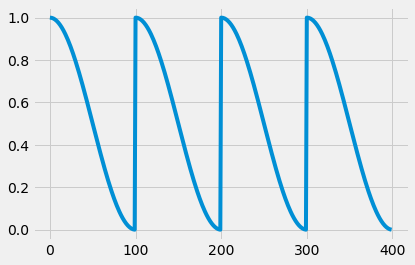

In [211]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)


In [212]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # (batch_size, seq_length, input_size) # 4, 1, 10
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # why is it 1???
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        
        print("x", x.shape)
        
        out, (hn, cn) = self.rnn(x, (h0, c0))
        
        print("out.shape", out.shape)
        print("out[:, -1, :].shape", out[:, -1, :].shape)
        print("out[0:2, 0, 0:4]", out[0:2, 0, 0:4])
        
        out = self.fc(out[:, -1, :]) # out[:, -1, :])
        
        print("after fc out", out)
        
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [213]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn)

Preparing datasets


In [214]:
bs = 8 # must be less than 70, cause we only have 70 years ...
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs)

Creating data loaders with batch size: 8


In [245]:
input_dim = 1 # features per time step - ONI = 1
hidden_dim = 256
layer_dim = 3
output_dim = 1
seq_dim = bs # amount of months - this is how many time steps in one feature

# Dummy EEG data (batch_size=100, seq_length=50, input_dim=10)
# X = torch.randn(100, 50, 10)  # (100 samples, 50 time steps, 10 features per time step)

lr = 0.0005
n_epochs = 500
iterations_per_epoch = len(trn_dl)
best_mse = 1000
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()
criterion = nn.MSELoss() # replaced cross entropy
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    print("* train *"*40)
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        
        
        
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        
        #print("x_batch", x_batch)
        #print("y_batch", y_batch)
        
        
        
        opt.zero_grad()
        out = model(x_batch)
        
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        
        sched.step()
        
        if i == 0:
            print("preds", out)
            print("y_batch", y_batch)
        
        
    
        
    
    model.eval()
    with torch.no_grad():
        print("* val *"*40)
        
        correct, total = 0, 0
        for x_val, y_val in val_dl:
            x_val, y_val = [t.cuda() for t in (x_val, y_val)]
            out = model(x_val)
            # preds = F.log_softmax(out, dim=1).argmax(dim=1) # NOT GOOD ...
            # preds = out

            # correct += (preds == y_val).sum().item()

            total += 1#  y_val.size(0)
            #print(out.detach().cpu().numpy())
            #print(y_val.detach().cpu().numpy())
            correct += mean_squared_error(out.detach().cpu().numpy(), y_val.detach().cpu().numpy())
        
    #print(correct)
    mse = correct / total

    
    if epoch % 5 == 0:
        
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. mean_squared_error.: {mse}')

    
    if mse > best_mse:
        trials = 0
        best_acc = acc
        # torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
    
            
print("Done")

Start model training
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0204, -0.0168, -0.0195,  0.0130],
        [-0.0205, -0.0167, -0.0194,  0.0131]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[-0.0403],
        [-0.0402],
        [-0.0404],
        [-0.0403],
        [-0.0404],
        [-0.0403],
        [-0.0404],
        [-0.0404]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds tensor([[-0.0403],
        [-0.0402],
        [-0.0404],
        [-0.0403],
        [-0.0404],
        [-0.0403],
        [-0.0404],
        [-0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0262, -0.0238, -0.0090,  0.0089],
        [-0.0262, -0.0238, -0.0090,  0.0089]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.3983],
        [0.3761],
        [0.3908],
        [0.3926],
        [0.3709],
        [0.4080],
        [0.4114],
        [0.3679]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0268, -0.0245, -0.0094,  0.0086],
        [-0.0262, -0.0242, -0.0098,  0.0089]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.4426],
        [0.4093]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** 

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0272, -0.0254, -0.0108,  0.0086],
        [-0.0273, -0.0255, -0.0107,  0.0085]], device='cuda:0')
after fc out tensor([[0.5237],
        [0.5465],
        [0.5349],
        [0.5512],
        [0.5972]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0272, -0.0254, -0.0108,  0.0085],
        [-0.0271, -0.0254, -0.0108,  0.0086]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5250],
  

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0278, -0.0261, -0.0111,  0.0083],
        [-0.0277, -0.0261, -0.0112,  0.0083]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6096],
        [0.5908],
        [0.6220],
        [0.5957],
        [0.6046],
        [0.6092],
        [0.5929],
        [0.6122]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0277, -0.0261, -0.0114,  0.0084],
        [-0.0279, -0.0262, -0.0112,  0.0083]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6077],
        [0.6212],
        [0.6366],
        [0.6205],
        [0.6230],
        [0.6228],
        [0.6294],
        [0.6245]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0279, -0.0263, -0.0114,  0.0083],
        [-0.0279, -0.0263, -0.0114,  0.0083]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6266],
        [0.6267],
        [0.6281],
        [0.6268],
        [0.6273],
        [0.6277],
        [0.6271],
        [0.6263]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0283, -0.0266, -0.0115,  0.0081],
        [-0.0282, -0.0266, -0.0116,  0.0081]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6744],
        [0.6754],
        [0.6788],
        [0.6752],
        [0.6737],
        [0.6760],
        [0.6763],
        [0.6739]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

after fc out tensor([[0.6183],
        [0.6184],
        [0.6224],
        [0.6194],
        [0.6262],
        [0.6229],
        [0.6179],
        [0.6174]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0280, -0.0263, -0.0112,  0.0082],
        [-0.0278, -0.0263, -0.0114,  0.0083]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6169],
        [0.6198],
        [0.6168],
        [0.6196],
        [0.6202],
        [0.6174],
        [0.6235],
        [0.6198]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0278, -0.0264, -0.0114,  0.0083],
        [-0.0279, -0.0263, -0.0113,  0.0082]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6206],
        [0.6214]], device='cuda:0', grad_fn=<Addm

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

after fc out tensor([[0.6817],
        [0.6812],
        [0.6810],
        [0.6812],
        [0.6855]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0284, -0.0269, -0.0117,  0.0081],
        [-0.0283, -0.0269, -0.0118,  0.0081]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6814],
        [0.6810],
        [0.6811],
        [0.6812],
        [0.6842],
        [0.6829],
        [0.6812],
        [0.6817]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds tensor([[0.6814],
        [0.6810],
        [0.6811]

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the


out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0278, -0.0261, -0.0109,  0.0082],
        [-0.0277, -0.0261, -0.0110,  0.0083]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5730],
        [0.5752],
        [0.5755],
        [0.5790],
        [0.5697],
        [0.5725],
        [0.5705],
        [0.5730]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0266, -0.0113,  0.0081],
        [-0.0282, -0.0266, -0.0112,  0.0081]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6305],
        [0.6354],
        [0.6204],
        [0.6239],
        [0.6221],
        [0.6222],
        [0.6232],
        [0.6185]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

after fc out tensor([[0.6444],
        [0.6444],
        [0.6466],
        [0.6488],
        [0.6491],
        [0.6449],
        [0.6447],
        [0.6444]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds tensor([[0.6444],
        [0.6444],
        [0.6466],
        [0.6488],
        [0.6491],
        [0.6449],
        [0.6447],
        [0.6444]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([0.6750, 0.7500, 0.7000, 0.3750, 0.5750, 0.7000, 0.5750, 0.4250],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0281, -0.0266, -0.0114,  0.0081],
        [-0.0279, -0.0266, -0.0115,  0.0082]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6263],
        [0.6261],
        [0.6272],
        [0.6315],
        [0.6263],
        [0.6283],
        [0.6260],
        [0.6277]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0280, -0.0264, -0.0112,  0.0082],
        [-0.0281, -0.0264, -0.0111,  0.0081]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6014],
        [0.6089],
        [0.5987],
        [0.5986],
        [0.5981],
        [0.5968],
        [0.5996],
        [0.6035]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0267, -0.0114,  0.0081],
        [-0.0280, -0.0267, -0.0115,  0.0082]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6328],
        [0.6315],
        [0.6322],
        [0.6335],
        [0.6315],
        [0.6343],
        [0.6331],
        [0.6316]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

after fc out tensor([[0.6286],
        [0.6286],
        [0.6287],
        [0.6298],
        [0.6287],
        [0.6287],
        [0.6291],
        [0.6322]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds tensor([[0.6286],
        [0.6286],
        [0.6287],
        [0.6298],
        [0.6287],
        [0.6287],
        [0.6291],
        [0.6322]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([0.5000, 0.7000, 0.8750, 0.5500, 0.6000, 0.5000, 0.5750, 0.7250],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0280, -0.0267, -0.0115,  0.0082],
        [-0.0282, -0.0267, -0.0113,  0.0081]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6293],
        [0.6285],
        [0.6282],
        [0.6293],
        [0.6307],
        [0.6285],
        [0.6319],
        [0.6283]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0276, -0.0262, -0.0110,  0.0083],
        [-0.0277, -0.0261, -0.0109,  0.0082]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5610],
        [0.5529],
        [0.5557],
        [0.5659],
        [0.5593],
        [0.5668],
        [0.5563],
        [0.5534]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0281, -0.0268, -0.0114,  0.0081],
        [-0.0281, -0.0268, -0.0114,  0.0081]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6439],
        [0.6208],
        [0.6376],
        [0.6410],
        [0.6098],
        [0.6213],
        [0.6391],
        [0.6505]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

after fc out tensor([[0.5563],
        [0.5589]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0281, -0.0269, -0.0115,  0.0081],
        [-0.0282, -0.0269, -0.0114,  0.0080]], device='cuda:0')
after fc out tensor([[0.6291],
        [0.6253],
        [0.6269],
        [0.6245],
        [0.6200]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0281, -0.0269, -0.0114,  0.0081],
        [-0.0282, -0.0269, -0.0114,  0.0081]], device='cuda:0')
after fc out tensor([[0.6276],
        [0.6217],
        [0.6244],
        [0.6204],
        [0.6122]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0283, -0.0268, -0.0113,  0.0080],
        [-0.0283, -0.0268, -0.0113,  0.0080]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6143],
        [0.6143],
        

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[0.5955],
        [0.5990],
        [0.5875],
        [0.5804],
        [0.5818],
        [0.5874],
        [0.5885],
        [0.5896]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([0.5750, 0.6750, 0.9000, 0.6500, 0.8500, 0.4750, 0.6250, 0.4250],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0281, -0.0268, -0.0113,  0.0081],
        [-0.0281, -0.0268, -0.0113,  0.0081]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6075],
        [0.6076],
        [0.5960],
        [0.5945],
        [0.5985],
        [0.6020],
        [0.6190],
        [0.6078]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0268, -0.0112,  0.0080],
        [-0.0281, -0.0270, -0.0114,  0.0080]], device='cuda:0',
       grad_fn=<Slice

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0271, -0.0115,  0.0080],
        [-0.0282, -0.0270, -0.0114,  0.0080]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6450],
        [0.6477],
        [0.6349],
        [0.6278],
        [0.6205],
        [0.6233],
        [0.6484],
        [0.6124]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0271, -0.0115,  0.0080],
        [-0.0282, -0.0271, -0.0115,  0.0080]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6491],
        [0.6508],
        [0.6359],
        [0.6406],
        [0.6185],
        [0.6407],
        [0.6363],
        [0.6459]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape to

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0285, -0.0274, -0.0117,  0.0079],
        [-0.0286, -0.0272, -0.0115,  0.0079]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6865],
        [0.6455],
        [0.6588],
        [0.6767],
        [0.6795],
        [0.6676],
        [0.6508],
        [0.6438]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0268, -0.0112,  0.0080],
        [-0.0282, -0.0269, -0.0112,  0.0080]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6053],
        [0.6025],
        [0.5996],
        [0.6031],
        [0.6234],
        [0.6207],
        [0.6103],
        [0.6148]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0269, -0.0112,  0.0080],
        [-0.0282, -0.0270, -0.0113,  0.0080]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6111],
        [0.6060]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0270, -0.0113,  0.0080],
        [-0.0282, -0.0270, -0.0113,  0.0080]], device='cuda:0')
after fc out tensor([[0.6212],
        [0.6109],
        [0.6157],
        [0.6088],
        [0.5925]], device='cuda:0')
* train ** train ** 

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0279, -0.0267, -0.0111,  0.0081],
        [-0.0279, -0.0267, -0.0110,  0.0081]], device='cuda:0')
after fc out tensor([[0.5763],
        [0.5735],
        [0.5746],
        [0.5728],
        [0.5697]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0281, -0.0267, -0.0109,  0.0080],
        [-0.0279, -0.0267, -0.0111,  0.0081]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5726],
        [0.5775],
        

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0282, -0.0270, -0.0111,  0.0079],
        [-0.0282, -0.0270, -0.0111,  0.0079]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5944],
        [0.6006],
        [0.6040],
        [0.5923],
        [0.5936],
        [0.5976],
        [0.5886],
        [0.5960]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0283, -0.0273, -0.0114,  0.0079],
        [-0.0285, -0.0271, -0.0112,  0.0079]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6291],
        [0.6139],
        [0.6219],
        [0.6239],
        [0.6197],
        [0.6171],
        [0.6183],
        [0.6228]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape to

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[-0.0281, -0.0269, -0.0111,  0.0080],
        [-0.0282, -0.0269, -0.0110,  0.0079]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5900],
        [0.5856],
        [0.5835],
        [0.5879],
        [0.5849],
        [0.5889],
        [0.5937],
        [0.5868]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0283, -0.0273, -0.0114,  0.0079],
        [-0.0283, -0.0273, -0.0114,  0.0079]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6244],
        [0.6260],
        [0.6274],
        [0.6277],
        [0.6161],
        [0.6250],
        [0.6315],
        [0.6245]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0288, -0.0276, -0.0116,  0.0078],
        [-0.0287, -0.0276, -0.0116

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[-0.0285, -0.0277, -0.0112,  0.0077],
        [-0.0285, -0.0277, -0.0112,  0.0077]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6064],
        [0.6061],
        [0.6024],
        [0.5987],
        [0.6093],
        [0.6068],
        [0.5909],
        [0.6015]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds tensor([[0.6064],
        [0.6061],
        [0.6024],
        [0.5987],
        [0.6093],
        [0.6068],
        [0.5909],
        [0.6015]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([0.5250, 0.5750, 0.6000, 0.2750, 0.6750, 0.8750, 0.4000, 0.9000],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0285, -0.0277, -0.0112,  0.0077],
        [-0.0285, -0.0277, -0.0112,  0.0077]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5972],
        [0.5978],
        [0.6156],
        [0.6108],
        [0.59

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0283, -0.0274, -0.0109,  0.0078],
        [-0.0283, -0.0274, -0.0109,  0.0078]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5651],
        [0.5631],
        [0.5678],
        [0.5679],
        [0.5598],
        [0.5609],
        [0.5646],
        [0.5649]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0285, -0.0277, -0.0111,  0.0077],
        [-0.0284, -0.0277, -0.0111,  0.0077]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5884],
        [0.5893],
        [0.5885],
        [0.5946],
        [0.5923],
        [0.5917],
        [0.5901],
        [0.5883]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0286, -0.0280, -0.0113,  0.0077],
        [-0.0287, -0.0280, -0.0112,  0.0076]], device='cuda:0')
after fc out tensor([[0.6146],
        [0.6156],
        [0.6147],
        [0.6152],
        [0.6170]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0287, -0.0280, -0.0112,  0.0076],
        [-0.0286, -0.0280, -0.0113,  0.0077]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6152],
  

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[0.6269],
        [0.6353],
        [0.6362],
        [0.6310],
        [0.6367],
        [0.6275],
        [0.6316],
        [0.6336]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0291, -0.0284, -0.0115,  0.0075],
        [-0.0291, -0.0283, -0.0115,  0.0075]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6617],
        [0.6637],
        [0.6664],
        [0.6628],
        [0.6617],
        [0.6674],
        [0.6717],
        [0.6660]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0290, -0.0282, -0.0114,  0.0075],
        [-0.0290, -0.0282, -0.0114,  0.0075]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6461],
        [0.6481],
        [0.6438],
        [0.6527],
        

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0284, -0.0278, -0.0111,  0.0077],
        [-0.0286, -0.0278, -0.0110,  0.0076]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5833],
        [0.5873]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0285, -0.0279, -0.0111,  0.0077],
        [-0.0285, -0.0278, -0.0110,  0.0077]], device='cuda:0')
after fc out tensor([[0.5862],
        [0.5882],
        [0.5868],
        [0.5881],
        [0.5914]], device='cuda:0')
* train ** train ** train ** train ** train 

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

after fc out tensor([[0.6384],
        [0.6325],
        [0.6334],
        [0.6373],
        [0.6236],
        [0.6274],
        [0.6313],
        [0.6373]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0291, -0.0285, -0.0113,  0.0074],
        [-0.0290, -0.0285, -0.0113,  0.0074]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6437],
        [0.6464],
        [0.6460],
        [0.6421],
        [0.6436],
        [0.6370],
        [0.6490],
        [0.6298]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0291, -0.0287, -0.0113,  0.0074],
        [-0.0291, -0.0285, -0.0113,  0.0074]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6532],
        [0.6347],
        [0.6440],
        [0.65

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[0.6227],
        [0.6228],
        [0.6280],
        [0.6295],
        [0.6324],
        [0.6305],
        [0.6345],
        [0.6291]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([0.6500, 0.6000, 0.5000, 0.5500, 0.6000, 0.7500, 0.7000, 0.5750],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0289, -0.0284, -0.0111,  0.0074],
        [-0.0288, -0.0285, -0.0111,  0.0075]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6138],
        [0.6172],
        [0.6116],
        [0.6160],
        [0.6147],
        [0.6195],
        [0.6170],
        [0.6150]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0291, -0.0285, -0.0112,  0.0074],
        [-0.0290, -0.0286, -0.0112,  0.0074]], device='cuda:0',
       grad_fn=<Slice

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0290, -0.0285, -0.0112,  0.0074],
        [-0.0290, -0.0285, -0.0112,  0.0074]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6261],
        [0.6233],
        [0.6221],
        [0.6204],
        [0.6283],
        [0.6210],
        [0.6260],
        [0.6267]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0290, -0.0284, -0.0111,  0.0074],
        [-0.0290, -0.0283, -0.0111,  0.0074]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6191],
        [0.6206],
        [0.6230],
        [0.6206],
        [0.6157],
        [0.6184],
        [0.6174],
        [0.6171]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape to

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0285, -0.0281, -0.0108,  0.0075],
        [-0.0285, -0.0280, -0.0108,  0.0075]], device='cuda:0')
after fc out tensor([[0.5704],
        [0.5639],
        [0.5665],
        [0.5616],
        [0.5484]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0286, -0.0279, -0.0108,  0.0075],
        [-0.0285, -0.0280, -0.0108,  0.0075]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5524],
        [0.5666],
        

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[-0.0290, -0.0287, -0.0111,  0.0074],
        [-0.0290, -0.0284, -0.0111,  0.0074]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6383],
        [0.5964],
        [0.6059],
        [0.5940],
        [0.6358],
        [0.6247],
        [0.5789],
        [0.6341]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0290, -0.0284, -0.0111,  0.0074],
        [-0.0289, -0.0283, -0.0111,  0.0074]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6466],
        [0.5988]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([0.5500, 0.9000, 0.8000, 0.7000, 0.6750, 0.6750, 0.3750, 0.7250],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0291, -0.0287, -0.0110,  0.0073],
        [-0.0290, -0.0288, -0.0110,  0.0074]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6102],
        [0.6097],
        [0.6110],
        [0.6098],
        [0.6083],
        [0.6096],
        [0.6092],
        [0.6100]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0291, -0.0286, -0.0110,  0.0073],
        [-0.0290, -0.0287, -0.0110,  0.0073]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6051],
        [0.6042],
        [0.6073],
        [0.6055],
        [0.6054],
        [0.6058],
        [0.6058],
        [0.6055]], device='cuda:0', grad_fn=<

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0292, -0.0292, -0.0111,  0.0073],
        [-0.0293, -0.0291, -0.0111,  0.0072]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6305],
        [0.6351],
        [0.6308],
        [0.6373],
        [0.6316],
        [0.6395],
        [0.6345],
        [0.6344]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0292, -0.0291, -0.0111,  0.0072],
        [-0.0292, -0.0290, -0.0110,  0.0072]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6221],
        [0.6245],
        [0.6290],
        [0.6230],
        [0.6254],
        [0.6250],
        [0.6223],
        [0.6249]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0292, -0.0291, -0.0110,  0.0072],
        [-0.0293, -0.0290, -0.0109,  0.0071]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6074],
        [0.6183],
        [0.6094],
        [0.6061],
        [0.6135],
        [0.6092],
        [0.6000],
        [0.5991]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0296, -0.0293, -0.0111,  0.0071],
        [-0.0296, -0.0294, -0.0111,  0.0071]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6587],
        [0.6507]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** 

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[0.6605],
        [0.6557],
        [0.6575],
        [0.6537],
        [0.6425]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0296, -0.0295, -0.0111,  0.0071],
        [-0.0296, -0.0295, -0.0111,  0.0071]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6503],
        [0.6525],
        [0.6578],
        [0.6587],
        [0.6499],
        [0.6630],
        [0.6592],
        [0.6603]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds tensor([[0.6503],
        [0.6525],
        [0.6578],
        [0.

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

preds tensor([[0.6271],
        [0.6263],
        [0.6326],
        [0.6140],
        [0.6322],
        [0.6375],
        [0.6312],
        [0.6383]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([0.8000, 0.9000, 0.9500, 0.5750, 0.7500, 0.7250, 0.6750, 0.7000],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0304, -0.0306, -0.0116,  0.0069],
        [-0.0304, -0.0306, -0.0116,  0.0069]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.7939],
        [0.7964],
        [0.8009],
        [0.8109],
        [0.7926],
        [0.7775],
        [0.7849],
        [0.7789]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0294, -0.0293, -0.0109,  0.0071],
        [-0.0294, -0.0294, -0.0109,  0.0071]], device='cuda:0',
       grad_fn=

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

after fc out tensor([[0.6291],
        [0.6380],
        [0.6411],
        [0.6315],
        [0.6414],
        [0.6346],
        [0.6376],
        [0.6252]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0295, -0.0293, -0.0110,  0.0071],
        [-0.0295, -0.0293, -0.0110,  0.0071]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6167],
        [0.6075],
        [0.6176],
        [0.6236],
        [0.6305],
        [0.6155],
        [0.6300],
        [0.6213]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0293, -0.0293, -0.0109,  0.0071],
        [-0.0293, -0.0293, -0.0109,  0.0071]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5920],
        [0.6000],
        [0.5992],
        [0.59

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0300, -0.0300, -0.0113,  0.0069],
        [-0.0299, -0.0303, -0.0112,  0.0069]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6864],
        [0.6950],
        [0.6864],
        [0.6964],
        [0.6906],
        [0.7020],
        [0.6775],
        [0.7036]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0295, -0.0293, -0.0110,  0.0070],
        [-0.0295, -0.0296, -0.0109,  0.0070]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6217],
        [0.6312],
        [0.6298],
        [0.6109],
        [0.6158],
        [0.6236],
        [0.6191],
        [0.6262]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape to

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[-0.0290, -0.0289, -0.0106,  0.0071],
        [-0.0290, -0.0290, -0.0106,  0.0071]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5470],
        [0.5452],
        [0.5444],
        [0.5449],
        [0.5430],
        [0.5449],
        [0.5460],
        [0.5437]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0292, -0.0294, -0.0107,  0.0071],
        [-0.0293, -0.0293, -0.0107,  0.0070]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5785],
        [0.5795]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0296, -0.0299, -0.0110,  0.0070],
        [-0.0296, -0.0298, -0.0110,  0.0070]], device='cuda:0')
after fc out tensor([[0.6344],
        [0.6317],
        [0.6323],
        [0.6300],
        [0.6234]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Siz

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

preds tensor([[0.5255],
        [0.5249],
        [0.5262],
        [0.5218],
        [0.5267],
        [0.5238],
        [0.5210],
        [0.5248]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([0.9250, 0.6000, 0.5250, 0.5000, 0.6750, 0.5250, 0.7500, 0.9000],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0294, -0.0296, -0.0108,  0.0070],
        [-0.0294, -0.0296, -0.0108,  0.0070]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5904],
        [0.5866],
        [0.5856],
        [0.5874],
        [0.5898],
        [0.5948],
        [0.5935],
        [0.5943]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0297, -0.0299, -0.0109,  0.0069],
        [-0.0297, -0.0299, -0.0109,  0.0069]], device='cuda:0',
       grad_fn=

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0294, -0.0297, -0.0108,  0.0070],
        [-0.0295, -0.0297, -0.0108,  0.0070]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5964],
        [0.6005],
        [0.5971],
        [0.5941],
        [0.5933],
        [0.6000],
        [0.6004],
        [0.5965]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0297, -0.0300, -0.0109,  0.0069],
        [-0.0297, -0.0300, -0.0109,  0.0069]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6261],
        [0.6341],
        [0.6326],
        [0.6301],
        [0.6417],
        [0.6297],
        [0.6250],
        [0.6374]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[0.5555],
        [0.5569]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0298, -0.0303, -0.0108,  0.0069],
        [-0.0298, -0.0302, -0.0108,  0.0069]], device='cuda:0')
after fc out tensor([[0.6141],
        [0.6145],
        [0.6136],
        [0.6135],
        [0.6137]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** tr

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([0.9250, 0.8000, 0.5000, 0.5750, 0.7000, 0.8500, 0.7000, 0.7750],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0308, -0.0314, -0.0112,  0.0067],
        [-0.0308, -0.0314, -0.0113,  0.0067]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.7615],
        [0.7601],
        [0.7639],
        [0.7629],
        [0.7620],
        [0.7607],
        [0.7603],
        [0.7577]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0293, -0.0297, -0.0105,  0.0069],
        [-0.0293, -0.0297, -0.0105,  0.0069]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5480],
        [0.5427],
        [0.5425],
        [0.5466],
        [0.5242],
        [0.5405],
        [0.5469],
        [0.5408]], device='cuda:0', grad_fn=<

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0300, -0.0305, -0.0107,  0.0068],
        [-0.0300, -0.0306, -0.0107,  0.0068]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6085],
        [0.6087],
        [0.6132],
        [0.6128],
        [0.6088],
        [0.6097],
        [0.6137],
        [0.6132]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0300, -0.0305, -0.0107,  0.0068],
        [-0.0300, -0.0306, -0.0107,  0.0068]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6105],
        [0.6172],
        [0.6189],
        [0.6165],
        [0.6117],
        [0.6101],
        [0.6139],
        [0.6171]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0297, -0.0305, -0.0104,  0.0067],
        [-0.0296, -0.0303, -0.0105,  0.0068]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5899],
        [0.5684],
        [0.5768],
        [0.5915],
        [0.5531],
        [0.5514],
        [0.5377],
        [0.5704]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0300, -0.0303, -0.0109,  0.0068],
        [-0.0301, -0.0309, -0.0107,  0.0067]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6331],
        [0.6102]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** 

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0302, -0.0310, -0.0107,  0.0067],
        [-0.0301, -0.0307, -0.0108,  0.0067]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6309],
        [0.6191],
        [0.6323],
        [0.6340],
        [0.6161],
        [0.6178],
        [0.6207],
        [0.6210]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds tensor([[0.6309],
        [0.6191],
        [0.6323],
        [0.6340],
        [0.6161],
        [0.6178],
        [0.6207],
        [0.6210]], device='cuda:0', grad_fn=<Ad

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[-0.0306, -0.0315, -0.0109,  0.0067],
        [-0.0306, -0.0313, -0.0110,  0.0067]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6912],
        [0.6940],
        [0.6862],
        [0.6888],
        [0.6767],
        [0.6879],
        [0.6933],
        [0.6946]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0300, -0.0306, -0.0106,  0.0067],
        [-0.0300, -0.0307, -0.0106,  0.0067]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5919],
        [0.5906],
        [0.5901],
        [0.5910],
        [0.5904],
        [0.5914],
        [0.5890],
        [0.5918]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0298, -0.0307, -0.0106,  0.0067],
        [-0.0300, -0.0306, -0.0106

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0301, -0.0311, -0.0106,  0.0066],
        [-0.0301, -0.0310, -0.0106,  0.0066]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5959],
        [0.5959],
        [0.5958],
        [0.5961],
        [0.5995],
        [0.5963],
        [0.5966],
        [0.5960]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0303, -0.0310, -0.0107,  0.0066],
        [-0.0302, -0.0311, -0.0106,  0.0066]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6087],
        [0.6080],
        [0.6081],
        [0.6088],
        [0.6085],
        [0.6077],
        [0.6103],
        [0.6093]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape to

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0306, -0.0315, -0.0108,  0.0066],
        [-0.0307, -0.0315, -0.0108,  0.0066]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6638],
        [0.6657],
        [0.6603],
        [0.6589],
        [0.6607],
        [0.6553],
        [0.6584],
        [0.6574]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0299, -0.0309, -0.0105,  0.0066],
        [-0.0300, -0.0308, -0.0105,  0.0066]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5757],
        [0.5771],
        [0.5789],
        [0.5770],
        [0.5780],
        [0.5753],
        [0.5756],
        [0.5780]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

after fc out tensor([[0.6037],
        [0.6047],
        [0.6067],
        [0.6050],
        [0.6063],
        [0.6045],
        [0.6076],
        [0.6076]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0305, -0.0313, -0.0107,  0.0065],
        [-0.0303, -0.0315, -0.0107,  0.0066]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6274],
        [0.6246],
        [0.6252],
        [0.6284],
        [0.6259],
        [0.6255],
        [0.6268],
        [0.6269]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0304, -0.0313, -0.0107,  0.0066],
        [-0.0303, -0.0314, -0.0107,  0.0066]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6222],
        [0.6200],
        [0.6200],
        [0.62

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0304, -0.0317, -0.0106,  0.0065],
        [-0.0304, -0.0317, -0.0106,  0.0065]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6069],
        [0.6093]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0304, -0.0317, -0.0106,  0.0065],
        [-0.0305, -0.0317, -0.0106,  0.0065]], device='cuda:0')
after fc out tensor([[0.6082],
        [0.6151],
        [0.6109],
        [0.6154],
        [0.6286]], device='cuda:0')
* train ** train ** train ** train ** train 

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0312, -0.0327, -0.0108,  0.0065],
        [-0.0312, -0.0326, -0.0108,  0.0065]], device='cuda:0')
after fc out tensor([[0.7112],
        [0.7064],
        [0.7077],
        [0.7040],
        [0.6957]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0312, -0.0325, -0.0108,  0.0065],
        [-0.0312, -0.0324, -0.0109,  0.0065]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.7041],
        [0.7016],
        

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0307, -0.0322, -0.0105,  0.0064],
        [-0.0307, -0.0320, -0.0106,  0.0065]], device='cuda:0')
after fc out tensor([[0.6397],
        [0.6267],
        [0.6321],
        [0.6226],
        [0.5986]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Siz

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0309, -0.0324, -0.0107,  0.0065],
        [-0.0309, -0.0324, -0.0107,  0.0065]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6607],
        [0.6601],
        [0.6637],
        [0.6625],
        [0.6670],
        [0.6572],
        [0.6614],
        [0.6559]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0301, -0.0313, -0.0103,  0.0064],
        [-0.0301, -0.0313, -0.0103,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.5442],
        [0.5433],
        [0.5460],
        [0.5440],
        [0.5455],
        [0.5476],
        [0.5439],
        [0.5472]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape to

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0309, -0.0323, -0.0105,  0.0063],
        [-0.0308, -0.0323, -0.0106,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6298],
        [0.6189],
        [0.6302],
        [0.6171],
        [0.6201],
        [0.6069],
        [0.6151],
        [0.6349]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0310, -0.0324, -0.0106,  0.0064],
        [-0.0309, -0.0324, -0.0106,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6385],
        [0.6390],
        [0.6315],
        [0.6508],
        [0.6413],
        [0.6314],
        [0.6282],
        [0.6388]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0307, -0.0322, -0.0105,  0.0064],
        [-0.0307, -0.0321, -0.0105,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6044],
        [0.6048],
        [0.6042],
        [0.6041],
        [0.6057],
        [0.6038],
        [0.6059],
        [0.6059]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0309, -0.0326, -0.0105,  0.0064],
        [-0.0309, -0.0324, -0.0106,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6329],
        [0.6354],
        [0.6399],
        [0.6374],
        [0.6344],
        [0.6352],
        [0.6362],
        [0.6332]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape to

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0313, -0.0329, -0.0107,  0.0064],
        [-0.0313, -0.0331, -0.0106,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6752],
        [0.6761],
        [0.6843],
        [0.6847],
        [0.6835],
        [0.6875],
        [0.6874],
        [0.6703]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([2, 9, 1])
out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0310, -0.0326, -0.0105,  0.0064],
        [-0.0310, -0.0325, -0.0105,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6368],
        [0.6289]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val 

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

out.shape torch.Size([2, 9, 256])
out[:, -1, :].shape torch.Size([2, 256])
out[0:2, 0, 0:4] tensor([[-0.0311, -0.0330, -0.0105,  0.0063],
        [-0.0311, -0.0325, -0.0107,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6524],
        [0.6376]], device='cuda:0', grad_fn=<AddmmBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *
x torch.Size([5, 9, 1])
out.shape torch.Size([5, 9, 256])
out[:, -1, :].shape torch.Size([5, 256])
out[0:2, 0, 0:4] tensor([[-0.0311, -0.0329, -0.0105,  0.0063],
        [-0.0311, -0.0328, -0.0105,  0.0064]], device='cuda:0')
after fc out tensor([[0.6461],
        [0.6360],
        [0.6400],
        [0.6325],
        [0.6138]], device='cuda:0')
* train ** train ** train ** train ** train 

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

tensor([[-0.0314, -0.0332, -0.0107,  0.0064],
        [-0.0315, -0.0333, -0.0107,  0.0064]], device='cuda:0')
after fc out tensor([[0.6682],
        [0.6894],
        [0.6785],
        [0.6930],
        [0.7313]], device='cuda:0')
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0314, -0.0333, -0.0107,  0.0064],
        [-0.0315, -0.0333, -0.0107,  0.0064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6742],
        [0.6810],
        [0.6568],
        [0.6961],
        [0.6536],
        [0.6774],
        [0.7006],
        [0

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

preds tensor([[0.6549],
        [0.6243],
        [0.6105],
        [0.6684],
        [0.6266],
        [0.6281],
        [0.6544],
        [0.6166]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([0.6750, 0.7500, 0.7250, 0.5750, 0.9500, 0.5500, 0.7250, 0.6000],
       device='cuda:0')
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0319, -0.0336, -0.0107,  0.0063],
        [-0.0319, -0.0336, -0.0107,  0.0063]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.7387],
        [0.7203],
        [0.7240],
        [0.6997],
        [0.7235],
        [0.7090],
        [0.7275],
        [0.7254]], device='cuda:0', grad_fn=<AddmmBackward0>)
x torch.Size([8, 9, 1])
out.shape torch.Size([8, 9, 256])
out[:, -1, :].shape torch.Size([8, 256])
out[0:2, 0, 0:4] tensor([[-0.0303, -0.0319, -0.0102,  0.0062],
        [-0.0303, -0.0320, -0.0102,  0.0062]], device='cuda:0',
       grad_fn=

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [246]:
r2_score([234, 231, 932], [234, 443, 123])

-1.1441293502851995

In [218]:
mean_squared_error([234], [239])

25.0

In [219]:
model.eval()

LSTMClassifier(
  (rnn): LSTM(1, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [235]:
test_dl = DataLoader(create_test_dataset(x_tst), batch_size=1, shuffle=False)

In [236]:
test = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
    print(batch)
    out = model(batch.cuda())
    print(out)
    # y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += out.tolist()

Predicting on test dataset
tensor([[[ 0.4000],
         [-0.1000],
         [-0.4000],
         [-0.5000],
         [-0.6000],
         [-0.7000],
         [-0.7000],
         [-0.6000],
         [-0.3000]]])
x torch.Size([1, 9, 1])
out.shape torch.Size([1, 9, 256])
out[:, -1, :].shape torch.Size([1, 256])
out[0:2, 0, 0:4] tensor([[-0.0183, -0.0142, -0.0131,  0.0152]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6143]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.6143]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[[ 0.3000],
         [ 0.3000],
         [ 0.1000],
         [-0.1000],
         [-0.4000],
         [-0.7000],
         [-0.8000],
         [-1.0000],
         [-0.9000]]])
x torch.Size([1, 9, 1])
out.shape torch.Size([1, 9, 256])
out[:, -1, :].shape torch.Size([1, 256])
out[0:2, 0, 0:4] tensor([[-0.0183, -0.0142, -0.0131,  0.0152]], device='cuda:0',
       grad_fn=<SliceBackward0>)
after fc out tensor([[0.6146]], device='cuda:0

In [237]:
test

[[0.6142611503601074],
 [0.6146284937858582],
 [0.6083777546882629],
 [0.6096799969673157],
 [0.6166022419929504]]

In [238]:
[(y[0] * (150 - 110) + 110) for y in test]

[134.5704460144043,
 134.58513975143433,
 134.33511018753052,
 134.38719987869263,
 134.66408967971802]

In [242]:
y_tst

55    0.425
56    0.400
57    0.425
58    0.500
59    0.425
Name: doy_cherry_peak_bloom, dtype: float64

In [243]:
y_tst * (150 - 110) + 110

55    127.0
56    126.0
57    127.0
58    130.0
59    127.0
Name: doy_cherry_peak_bloom, dtype: float64

55    0.425
56    0.400
57    0.425
58    0.500
59    0.425
Name: doy_cherry_peak_bloom, dtype: float64

# RNN try, failed ********** ********** **********

In [ ]:
class BasicRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(BasicRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # n_inputs X n_neurons
        self.Wy = torch.randn(n_neurons, n_neurons) # n_neurons X n_neurons
        
        self.b = torch.zeros(1, n_neurons) # 1 X n_neurons
    
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # batch_size X n_neurons
        
        return self.Y0, self.Y1

In [ ]:
N_INPUT = 3 # number of features in input
N_NEURONS = 5 # number of units in layer

X0_batch = torch.tensor([[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        dtype = torch.float) #t=0 => 4 X 3

X1_batch = torch.tensor([[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]],
                        dtype = torch.float) #t=1 => 4 X 3

model = BasicRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

In [ ]:
print(Y0_val)
print(Y1_val)